# Unsupervised Quantum Learning with Max-cut: 2+ Clusters

This notebook is an example of unsupervised machine learning on a quantum computer. The data used are from the iris dataset.

In the [previous notebook](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut.ipynb), the max-cut problem was solved using QAOA which theoretically gives a quantum speed up to unsupervised learning. Solving the max-cut problem is a binary classifier though. So, if the data are more naturally separated into three or more groups, we're sunk! ... or are we?

## Quantum Divisive Hierarchical Clustering

One solution is to apply a divisive ("top-down") [hierarchial clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) scheme. This scheme starts with the whole dataset (the top). Using a binary classifier (like QAOA solving max-cut), the data is split into two child clusters. We then use the binary classifier to break each child cluster in two--resulting in four clusters. We continue this recursive application of the binary classifier on each child cluster until all data points sit in their own cluster (the bottom). For QAOA solving max-cut, a divisive hierarchical clustering algorithm would execute as follows: (0) solve the max-cut problem on the entire dataset resulting in two child clusters, (1) solve the max-cut problem on each child cluster, (2) repeat (1) until nearly every data point is in an individual cluster.

You may be wondering, how would having every data point in its own cluster be useful? Answer: it isn't. But! Stopping before that point is very useful. Let's say our intuition tells us the data of interest has a few clusters. We can cleverly pick a stopping point **before** the every-data-point-is-its-own-cluster level. Ideally, the algorithm will stop at just a few clusters. We'd need some stop criteria that tells us the data is separated enough. Including the stop criteria modifies the divisive hierarchical clustering algorithm to: (0) solve the max-cut problem on the entire dataset resulting in two child clusters, (1) solve the max-cut problem on each child cluster, (2) repeat (1) until nearly every data point is in an individual cluster, (3) post-process the resulting tree of clusters according to the stop criteria.

Let's get to it!

In [1]:
import numpy as np
import pandas as pd
from numba import jit
from sklearn.datasets import load_iris

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Packages needs to access an IBM quantum computer. Not necessary for simulator.
# from qiskit import IBMQ
# IBMQ.load_account()  # Load account from disk

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [2]:
# Import Iris dataset
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names).astype(str)
print('number of data points:', len(df))

number of data points: 150


The iris dataset contains 150 data points. As in the previous notebook, we'll need to chop this down to ~12 points for a reasonable execution time. Different from the previous notebook, we'll keep all three species! 

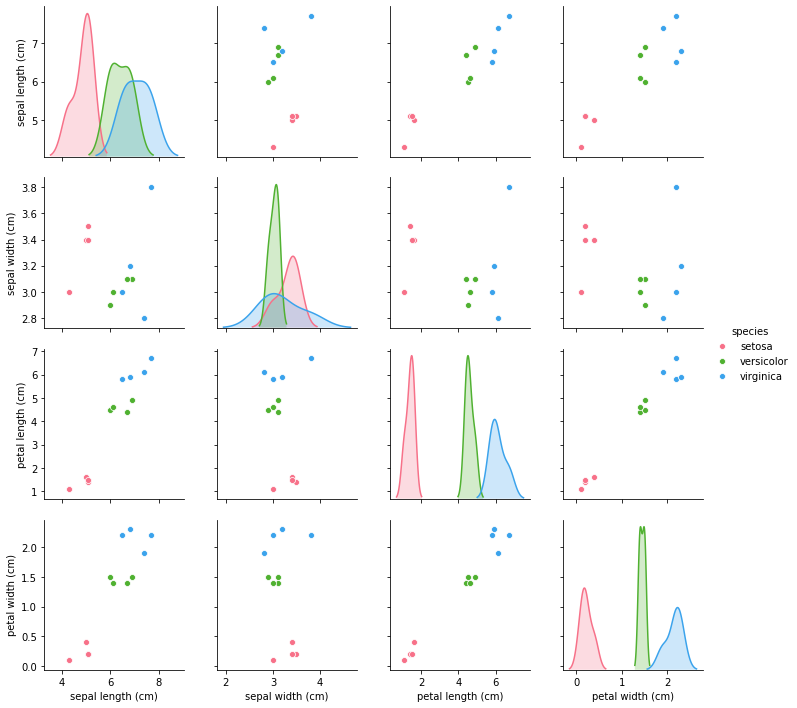

In [3]:
# Generate subset of data with fewer data points
df_sub = df.iloc[::13,:].reset_index(drop=True)

# View data
sns.pairplot(data=df_sub, hue="species", palette="husl")
plt.show()

In [4]:
# Remove species labels (otherwise it's not unsupervised learning!)
df_sub_wo_labels = df_sub.loc[:,['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']]

Now that the data is all squared away, let's solve the max-cut problem with QAOA just as we did in the [previous notebook](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut.ipynb). This time, we want to solve the max-cut problem on each resulting child cluster as well. To do this, we will track how the data is cut each iteration and solve the max-cut problem on each resulting child cluster.

Each division of the dataset into child clusters can be thought of as generating new leaf nodes on a binary tree. The root node is the whole dataset. The root node's two child nodes each contain roughly half of the dataset (assuming balanced data). Their child nodes contain roughly one quarter of the dataset and so on. Since the end case in the divisive hierarchical scheme has all $n$ data points in their own clusters, there must be $n$ leaf nodes. For a well balanced binary tree, that leaves (no pun intended) the height $h=\log_2{\left(n+1\right)}$. For our situation this means at least $h$ iterations need to be completed.

Let's put these pieces together. First we'll need to define a function that computes the $l^2\text{-norm}$ as done in the previous notebook.

In [5]:
# Helper function for iterative QAOA solving

# Computes pairwise L2-norms (@jit gives ~x10 speed up on my laptop)
@jit(nopython=True)
def calc_w(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    for i in range(0, n_instances):
        for j in range(0, n_instances):
            w[i, j] = np.linalg.norm(data_array[i] - data_array[j])
    return w

Next, we do the heavy lifting. The max-cut problem is solved recursively over the child clusters a total of $h$ times. Much of the code will be familiar to you from the previous notebook. The for loops and if statements are the only new machinery. They track the recursive component of the hierarchical scheme.

In [6]:
# THIS MAY TAKE SEVERAL MINUTES

# Compute minimum number of iterations (i.e. height of a balanced binary tree)
h = int(np.log2(len(df_sub_wo_labels) + 1))

# Copy df_sub_wo_labels so future manipulations don't affect df_sub_wo_labels
data = df_sub_wo_labels.copy()

# QAOA hyperparameters and backend initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()  # Classical optimizer
backend = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

# provider = IBMQ.get_provider(group='open')  # Load provider to access IBM's cloud services
# backend = provider.get_backend('ibmq_essex')  # Compute on one of IBM's quantum computer

quantum_instance = QuantumInstance(backend, shots=1, skip_qobj_validation=False)

# Iterate over height of dataset tree
for i in range(0, h):

    # Initialize label and cut weight columns to later store QAOA output
    data.loc[:, 'clusters_iter_' + str(i)] = np.nan
    data.loc[:, 'cuts_iter_' + str(i)] = np.nan
    
    # Select data from the previous child clusters
    dfs = []
    if i > 0:
        cluster_range = data.loc[:, 'clusters_iter_' + str(i - 1)].unique()
        for j in cluster_range:
            df_cluster = data.loc[data['clusters_iter_' + str(i - 1)] == j, data.columns[:4]]
            # if df_cluster length is 1 then it can't be further cut, so only consider lengths > 1
            if len(df_cluster.index) > 1:
                dfs.append(df_cluster)
    else:
        dfs.append(data[data.columns[:4]])

    # Solve max-cut with QAOA on each child cluster
    for j, df_part in enumerate(dfs):
        
        # Calculate pairwise distances between points
        w = calc_w(df_part.values)
        
        # Initialize QAOA and execute
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Store cluster results (label and weight). Labels must be unqiue each iteration hence + 2*j
        df_part.loc[:, 'clusters_iter_' + str(i)] = max_cut.get_graph_solution(x) + 2 * j
        df_part.loc[:, 'cuts_iter_' + str(i)] = max_cut.max_cut_value(x, w)
        
        # Update data with new results
        data.update(df_part)

    print('Iteration', i+1, 'of', h, 'completed')  # Show execute status

Iteration 1 of 3 completed
Iteration 2 of 3 completed
Iteration 3 of 3 completed


Once the results are in, let's take a look at how the clustering compares to the known species labeling.

In [7]:
# Include results from QAOA in df_sub dataframe for comparison to species label
for i in range(0, h):
    df_sub.loc[:, 'clusters_iter_' + str(i)] = data.loc[:, 'clusters_iter_' + str(i)]
    df_sub.loc[:, 'cuts_iter_' + str(i)] = data.loc[:, 'cuts_iter_' + str(i)]
df_sub

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,clusters_iter_0,cuts_iter_0,clusters_iter_1,cuts_iter_1,clusters_iter_2,cuts_iter_2
0,5.1,3.5,1.4,0.2,setosa,0.0,150.460827,0.0,2.974861,0.0,0.561177
1,4.3,3.0,1.1,0.1,setosa,0.0,150.460827,1.0,2.974861,NaN,NaN
2,5.0,3.4,1.6,0.4,setosa,0.0,150.460827,0.0,2.974861,1.0,0.561177
3,5.1,3.4,1.5,0.2,setosa,0.0,150.460827,0.0,2.974861,0.0,0.561177
4,6.9,3.1,4.9,1.5,versicolor,1.0,150.460827,3.0,30.857643,3.0,3.252945
5,6.7,3.1,4.4,1.4,versicolor,1.0,150.460827,3.0,30.857643,3.0,3.252945
6,6.0,2.9,4.5,1.5,versicolor,1.0,150.460827,3.0,30.857643,2.0,3.252945
7,6.1,3.0,4.6,1.4,versicolor,1.0,150.460827,3.0,30.857643,2.0,3.252945
8,6.5,3.0,5.8,2.2,virginica,1.0,150.460827,2.0,30.857643,5.0,4.912491
9,7.7,3.8,6.7,2.2,virginica,1.0,150.460827,2.0,30.857643,4.0,4.912491


Under the "cluster_2" column, we see the clustering is not at all similar to the species labeling. This is because each data point is nearly in its own cluster. Let's assume we don't already know how the data should cluster, but we do have an educated guess that there is some "best" number of clusters less than the number of data points. As discussed in the introduction, we need to introduce some stop criteria. Let's first take a lesson from k-means.

## Stop Criteria Part 1: the elbow rule

To find the best clustering, we first follow the elbow rule just like in k-means.

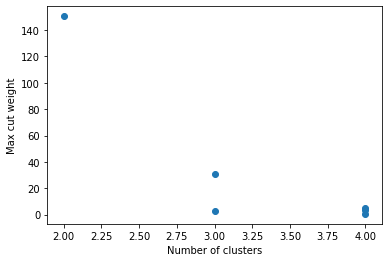

In [8]:
# Plot max-cut weights vs number of clusters created
cluster_num = []  # initialize x-axis array
cuts = []  # initialize y-axis array

# Extract max-cut weights and associated number of clusters from results in df_sub
for i in range(0, h):
    # Collect max-cut weights
    cuts += list(df_sub['cuts_iter_'+str(i)].unique())
    # Number how many clusters have been made for this cut
    cut_off = 2**i
    for j in range(0, cut_off):
        cluster_num.append(i+2)

plt.scatter(cluster_num, cuts)
plt.xlabel('Number of clusters')
plt.ylabel('Max cut weight')
plt.show()

We see from the plot, the elbow is at three clusters. However, which of the two possible 3 cluster configurations do we choose? Answer: the one with the higher cut weight. The higher cut weight indicates a more separated graph--exactly what we want.

In summary, we followed the elbow rule and found we should stop at the max-cut with a weight of ~30. To get to this cut, we need to traverse the tree of max-cuts until we get to it. Let's dive in.

## Stop Criteria Part 2: depth-first-search

The task of finding the stopping point is best recast as a depth-first-search where the tree being searched is made from all the computed cut weights. Starting at the root node (150.5 when I ran it on my machine), we traverse down the tree to leaves with the **highest** cut weights. Along the way we "keep" those cuts we've encountered until there are as many clusters as the elbow rule advises.

Let's visualize with a graph

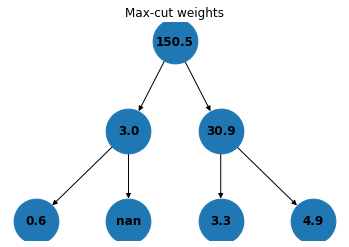

In [9]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Initialize graph
G = nx.DiGraph()

# Set root node as weight of the very first cut; in this case 150.5
G.add_node("{:.1f}".format(cuts[0]))

# Add the remaining cut weights to the tree
for cut in cuts[1:]:
    if np.isnan(cut):  # ignore nan cut weights
        continue
    G.add_node("{:.1f}".format(cut))

# Add edges from parent to child clusters
for i in range(int(np.log2(len(cuts)+1))):
    G.add_edge("{:.1f}".format(cuts[i]), "{:.1f}".format(cuts[2*i+1]))
    G.add_edge("{:.1f}".format(cuts[i]), "{:.1f}".format(cuts[2*i+2]))

# Plot graph
plt.title('Max-cut weights')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000)
plt.show()

Following the stop criteria rules, we transverse the tree starting at the root node 150.5 when I ran this code. Since $30.9 > 3.0$, we move to 30.9 and keep that cut. At this point, the two cuts 150.5 and 30.9 generate 3 clusters labeled 0.0, 2.0, and 3.0. Since the elbow rule tells us to stop at 3 clusters, we stop here and we're done! Let's see how the stop criteria does by comparing these 3 clusters to the original species labeling.

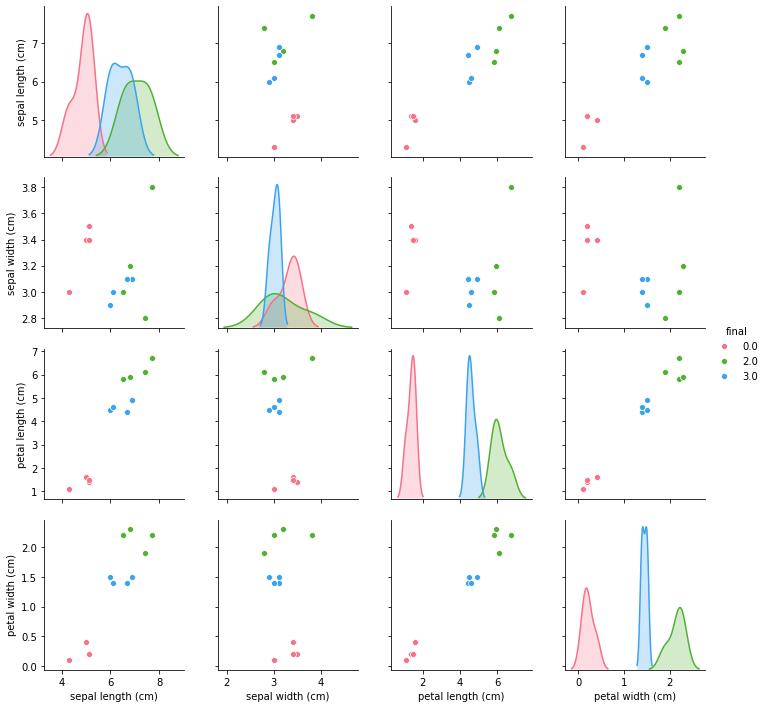

In [10]:
# maximum number of clusters as given by the elbow rule
max_clusters = 3

# Initialize final clustering column
df_sub.loc[:, 'final'] = np.nan

# Extract clustering based on the stop criteria
for (cluster, cut_weight) in zip(df_sub[df_sub.columns[5::2]],df_sub[df_sub.columns[6::2]]):
    # Find the maximum cut for this particular column of data
    maxim = df_sub[cut_weight].max()
    df_sub['final'].update(df_sub[cluster][df_sub[cut_weight] == maxim])
    if len(df_sub['final'].unique()) >= max_clusters:  # stop including clusters once the number of clusters reaches the elbow rule limit
        break

# Constrain data to final clustering assignments
df_sub_plot = df_sub[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'final']]

# Visualize clustering
sns.pairplot(data=df_sub_plot, hue='final', palette="husl", vars=df_sub.columns[:4])
plt.show()

The plots look identical to the reduced dataset! Setosa is all in cluster 0; versicolor is all in cluster 2; and virginica is all in cluster 3. The divisive hierarchical quantum clustering did a great job!

This technique uses the same quantum algorithm as the last notebook. The advantage presented here is simply in how we use the quantum algorithm. By post-processing the results in a divisive hierarchical way, we can build more complex unsupervised learning models while leveraging quantum speedup on [NISQ](https://arxiv.org/abs/1801.00862) devices.

### Your turn
A great way to learn is to get your hands dirty. Mess around with this notebook and see what happens! Here are some questions to inspire your play:
* What happens if I create data for a **fourth species**?
* How could this scheme (or an adaptation) allow for larger datasets?
* How do these results change when I execute on a real quantum computer?
* What happens if I change the number of adiabatic steps (p) in the QAOA hyperparameters?
* What if I use VQE instead of QAOA to find the ground state of the cost Hamiltonian?